# Training and evaluation with the built-in methods

## Setup
## 环境设置

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Introduction
## 章节介绍
This guide covers training, evaluation, and prediction (inference) models when using built-in APIs for training & validation (such as Model.fit(), Model.evaluate() and Model.predict()).

If you are interested in leveraging fit() while specifying your own training step function, see the [Customizing what happens in fit() guide.](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/)

If you are interested in writing your own training & evaluation loops from scratch, see the guide ["writing a training loop from scratch".](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch/)

In general, whether you are using built-in loops or writing your own, model training & evaluation works strictly in the same way across every kind of Keras model -- Sequential models, models built with the Functional API, and models written from scratch via model subclassing.

This guide doesn't cover distributed training, which is covered in our guide to [multi-GPU & distributed training.](https://keras.io/guides/distributed_training/)

本指南涵盖了使用内置API（如Model.fit(), Model.evaluate() 和 Model.predict()）进行训练时的训练、评估和预测模型


如果你对在指定训练模型训练步骤函数的同时应用fit（），请参考这篇[指南](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/)

如果你对从零开始构建自己的训练/评估循环有兴趣，请参阅这篇这篇[指南](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch/)

一般而言，无论你是使用内置的指令或者自己构建的指令，对于Keras的各类模型（顺序模型，函数式模型，通过模型子类构建的新模型）而言，其训练和评估过程是严格按照相同的方式进行的

这篇指南没有包含分布式训练的内容，这部分内容请查阅这篇[指南](https://keras.io/guides/distributed_training/)

## API overview: a first end-to-end example
## API概述：一个端到端的示例

When passing data to the built-in training loops of a model, you should either use NumPy arrays (if your data is small and fits in memory) or tf.data Dataset objects. In the next few paragraphs, we'll use the MNIST dataset as NumPy arrays, in order to demonstrate how to use optimizers, losses, and metrics.

Let's consider the following model (here, we build in with the Functional API, but it could be a Sequential model or a subclassed model as well):

当你传递数据到一个模型的内置训练循环时，你可以选择使用Numoy数组（如果你的数据比较小且可以在内存中进行训练）或者tf.data数据集对象（来进行传递）。在接下来的部分里，我们将使用Numpy数组格式的MNIST数据集来演示如何设置优化器，损失函数和评估指标

让我们来看看接下来的模型（演示用的模型是用函数式API构建的，但1其实它可以用顺序模型或者模型子类来进行构建）

In [2]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

Here's what the typical end-to-end workflow looks like, consisting of:
1. Training
2. Validation on a holdout set generated from the original training data
3. Evaluation on the test data

一个典型的端到端模型工作流程如下：
1. 训练
2. 使用原始数据集上生成的验证集机型模型验证
3. 使用测试数据对模型进行评估

In [3]:
# use MNIST data for this example
# 使用MNIST数据进行演示

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
# 数据处理（数据结类型是Numpy数组）
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [7]:
# specify the training configuration (optimizer, loss, metrics)
# 设定训练配置（优化器，损失函数和评估指标）
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer 优化器
    # Loss function to minimize 损失函数最小化
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor 采用一系列指标来进行监测
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

We call fit(), which will train the model by slicing the data into "batches" of size batch_size, and repeatedly iterating over the entire dataset for a given number of epochs.
我们调用fit（）方法，这会开始训练模型：数据将会根据所设定的批量大量划分为多个数据批量，然后模型会训练整个数据集，只到训练次数达到我们所设定的次数

In [8]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    # 每一次训练结束后，我们通过返回模型验证信息，来监控验证损失和指标
    validation_data=(x_val, y_val),
)

Fit model on training data
Epoch 1/2
782/782 [==============================] - 3s 3ms/step - loss: 0.5777 - sparse_categorical_accuracy: 0.8384 - val_loss: 0.2166 - val_sparse_categorical_accuracy: 0.9382
Epoch 2/2
782/782 [==============================] - 2s 2ms/step - loss: 0.1754 - sparse_categorical_accuracy: 0.9482 - val_loss: 0.1353 - val_sparse_categorical_accuracy: 0.9614


In [9]:
# The returned history object holds a record of the loss values and metric values during training
# 返回history对象，这个对象记录了训练过程中的损失值和指标值
history.history

{'loss': [0.3442656397819519, 0.1592882126569748],
 'sparse_categorical_accuracy': [0.9027000069618225, 0.9524800181388855],
 'val_loss': [0.21663400530815125, 0.1353076845407486],
 'val_sparse_categorical_accuracy': [0.9381999969482422, 0.9613999724388123]}

In [10]:
# We evaluate the model on the test data via evaluate()
# 我们通过evaluate（）方法，在测试集上对模型进行评估
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# 输出预测值（最后一层的输出：概率）
# on new data using `predict`
# 在新的数据上应用predict（）方法
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
79/79 [==============================] - 0s 1ms/step - loss: 0.1358 - sparse_categorical_accuracy: 0.9603
test loss, test acc: [0.13578011095523834, 0.9603000283241272]
Generate predictions for 3 samples
predictions shape: (3, 10)


Now, let's review each piece of this workflow in detail.

现在，让我们详细回顾这一工作流程的中每一个部分

## The compile() method: specifying a loss, metrics, and an optimizer
## compile()方法：设定损失函数，指标和优化器 

To train a model with fit(), you need to specify a loss function, an optimizer, and optionally, some metrics to monitor.

You pass these to the model as arguments to the compile() method:

为了用fit（）方法训练模型，你需要先设定好损失函数，优化器，以及一些监控指标（如果有需要的话）

你将这些信息作为参数，通过compile（）方法将其传递给模型

In [11]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

The metrics argument should be a list -- your model can have any number of metrics.

If your model has multiple outputs, you can specify different losses and metrics for each output, and you can modulate the contribution of each output to the total loss of the model. You will find more details about this in the **Passing data to multi-input, multi-output models** section.

指标参数可以是一个列表，这意味着你的模型可以有多个评估指标

如果你的模型有多种输出，你可以为每一类输出设定不同的损失函数和指标，还可以控制每一类数据对模型整体损失的贡献。你可以在**传递数据给多输入/输出模型**一节了解到更多关于这一内容的细节

Note that if you're satisfied with the default settings, in many cases the optimizer, loss, and metrics can be specified via string identifiers as a shortcut:

注意：如果你对默认设置感到满意，在很多情况下，可以用字符串作为一个快捷方式来对优化器、损失函数和指标进行设置。

In [12]:
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

For later reuse, let's put our model definition and compile step in functions; we will call them several times across different examples in this guide.

为了之后可以复用，我们将模型的定义和汇编过程分别定义成函数。在这篇指南中，我们将在多个不同的示例中调用这些函数。

In [13]:
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model

### Many built-in optimizers, losses, and metrics are available
### 一些可用的内置优化器，损失函数和指标

In general, you won't have to create your own losses, metrics, or optimizers from scratch, because what you need is likely to be already part of the Keras API:

Optimizers:
1. SGD() (with or without momentum)
2. RMSprop()
3. Adam()
4. etc.

Losses:
1. MeanSquaredError()
2. KLDivergence()
3. CosineSimilarity()
4. etc.

Metrics:
1. AUC()
2. Precision()
3. Recall()
4. etc.

一般而言，你并不需要从头创建一个损失函数、指标或者优化器，因为你需要的东西很可能已经内置进了KerasAPI

优化器：
1. SGD() (with or without momentum)
2. RMSprop()
3. Adam()
4. etc.

损失函数：
1. MeanSquaredError()
2. KLDivergence()
3. CosineSimilarity()
4. etc.

指标：
1. AUC()
2. Precision()
3. Recall()
4. etc.

### Custom losses
### 自定义损失函数
If you need to create a custom loss, Keras provides two ways to do so.

The first method involves creating a function that accepts inputs y_true and y_pred. The following example shows a loss function that computes the mean squared error between the real data and the predictions

如果你需要创造一个自定义损失函数，Keras提供了两种方法。

第一种方式是创造一个函数，将真实值和预测值作为输入。 接下来的例子展示了一个计算均方误差的损失函数

In [14]:
def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=custom_mean_squared_error)

# We need to one-hot encode the labels to use MSE
y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

782/782 [==============================] - 2s 2ms/step - loss: 0.0278


If you need a loss function that takes in parameters beside y_true and y_pred, you can subclass the tf.keras.losses.Loss class and implement the following two methods:

1. __init__(self): accept parameters to pass during the call of your loss function
2. call(self, y_true, y_pred): use the targets (y_true) and the model predictions (y_pred) to compute the model's loss


Let's say you want to use mean squared error, but with an added term that will de-incentivize prediction values far from 0.5 (we assume that the categorical targets are one-hot encoded and take values between 0 and 1). This creates an incentive for the model not to be too confident, which may help reduce overfitting (we won't know if it works until we try!).

如果你需要一个损失函数，其参数不仅是真实值和预测值，那么你可以构建一个tf.keras.losses.Loss的类。这需要调用两个方法来实现：
1. __init__(self): 接受参数并在调用损失函数时传递给它
2. 调用(self, y_true, y_pred)： 用真实值和模型预测值来计算模型损失

我们假设你打算使用均方误差，但是加入一个新的项来惩罚那些远离0.5的值（假设分类变量是独热编码的（0-1）），这会形成一种激励，让模型不那么自信（不容易预测为0或者1，因为远离0.5会带来额外的损失惩罚），这样有助于减少过拟合问题（在实验在这个新想法之前，我们都无法知道它是否有效）

In [15]:
class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super().__init__(name=name)
        self.regularization_factor = regularization_factor

    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse + reg * self.regularization_factor


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomMSE())

y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

782/782 [==============================] - 2s 2ms/step - loss: 0.0489


### Custom metrics
### 自定义指标
If you need a metric that isn't part of the API, you can easily create custom metrics by subclassing the tf.keras.metrics.Metric class. You will need to implement 4 methods:

1. __init__(self), in which you will create state variables for your metric.
2. update_state(self, y_true, y_pred, sample_weight=None), which uses the targets y_true and the model predictions y_pred to update the state variables.
3. result(self), which uses the state variables to compute the final results.
4. reset_states(self), which reinitializes the state of the metric.

State update and results computation are kept separate (in update_state() and result(), respectively) because in some cases, the results computation might be very expensive and would only be done periodically.

如果你需要一个没有收录在API中的指标，你可以轻易地通过tf.keras.metrics.Metric类来创建一个自定义指标。你需要通过调用四个方法来实现：
1. __init__(self)，在这里你可以为你的指标创建一个静态变量
2. update_state(self, y_true, y_pred, sample_weight=None),这将使用真实值和预测值来更新这个静态变量
3. result(self), 这个方法将用静态变量来计算最终结果
4. reset_states(self)，这个方法将重新初始化这个指标的状态（以备下一次使用）

状态更新和结果计算是分离的（两者分别在update_state() 和result()中进行）,因为在一些情况下，结果计算的成本会非常高，并且是周期性的

Here's a simple example showing how to implement a CategoricalTruePositives metric that counts how many samples were correctly classified as belonging to a given class:

这里是一个展示实现CategoricalTruePositives指标例子。这个指标会统计有多少样本被正确的分类到了所给予的类别中

In [ ]:
class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        # 在每一次的训练后，指标会被重置为初始状态
        self.true_positives.assign(0.0)


model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CategoricalTruePositives()],
)
model.fit(x_train, y_train, batch_size=64, epochs=3)

### Handling losses and metrics that don't fit the standard signature
### 处理不符合一般规范的损失函数和指标

The overwhelming majority of losses and metrics can be computed from y_true and y_pred, where y_pred is an output of your model -- but not all of them. For instance, a regularization loss may only require the activation of a layer (there are no targets in this case), and this activation may not be a model output.

In such cases, you can call self.add_loss(loss_value) from inside the call method of a custom layer. Losses added in this way get added to the "main" loss during training (the one passed to compile()). Here's a simple example that adds activity regularization (note that activity regularization is built-in in all Keras layers -- this layer is just for the sake of providing a concrete example):

绝大部分的损失函数和指标都是基于真实值和预测值的（预测值就是模型的输出），但并不是所有的皆是如此。例如，一个正则化损失可能只需要知道层的激活函数即可（这种情况下，没有预测变量），而且激活函数也不是模型的输出

在这类情况下，你可以从自定义层的内部方法中调用self.add_loss(loss_value)方法。以这种方式添加的损失会在训练时（通过传递给compile（））加入“主要”损失之中。这里有李哥加入激活正则化（对层的输出进行正则化）的示例（注意所有的Keras层都内置了激活正则化，这里只是做一个示例）

In [17]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert activity regularization as a layer
# 插入激活正则化
x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

# The displayed loss will be much higher than before
# 输出的损失会比之前的大很多
# due to the regularization component.
# 因为加入了正则项
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 2s 2ms/step - loss: 3.6878


In [18]:
# You can do the same for logging metric values, using add_metric()
# 你可以用add_metric()方法对日志指标做相同的事

class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        # The `aggregation` argument defines
        # how to aggregate the per-batch values
        # over each epoch:
        # in this case we simply average them.
        # ‘aggregation’参数定义了如何对每次训练中的每个批次进行聚合，在这里我们只需要简单地计算均值即可
        self.add_metric(
            keras.backend.std(inputs), name="std_of_activation", aggregation="mean"
        )
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert std logging as a layer.
x = MetricLoggingLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 2s 2ms/step - loss: 0.5646 - std_of_activation: 0.9570


In the Functional API, you can also call model.add_loss(loss_tensor), or model.add_metric(metric_tensor, name, aggregation).

在函数式API中，你同样可以调用model.add_loss(loss_tensor)或者model.add_metric(metric_tensor, name, aggregation).

In [19]:
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x2 = layers.Dense(64, activation="relu", name="dense_2")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.add_loss(tf.reduce_sum(x1) * 0.1)

model.add_metric(keras.backend.std(x1), name="std_of_activation", aggregation="mean")

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 2s 2ms/step - loss: 3.2508 - std_of_activation: 0.0018


**Note** that when you pass losses via add_loss(), it becomes possible to call compile() without a loss function, since the model already has a loss to minimize.

**注意** 你可以通过 add_loss()来传递损失函数，然后再调用compile（）时不加入损失函数。因为这时模型已经拥有了需要最小化的损失函数

Consider the following LogisticEndpoint layer: it takes as inputs targets & logits, and it tracks a crossentropy loss via add_loss(). It also tracks classification accuracy via add_metric().

思考接来下展示的 LogisticEndpoint层： 它将targets和logits作为输入，并且通过add_loss()方法计算交换熵损失。 它同样也通过add_metric()来计算分类准确性

In [20]:
class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy()

    def call(self, targets, logits, sample_weights=None):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)

        # Log accuracy as a metric and add it
        # to the layer using `self.add_metric()`.
        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")

        # Return the inference-time prediction tensor (for `.predict()`).
        return tf.nn.softmax(logits)

You can use it in a model with two inputs (input data & targets), compiled without a loss argument, like this:
你可以在接受两个输入的模型中应用这个技巧，在没有损失函数的情况下进行汇编，就像这样：

In [21]:
import numpy as np

inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name="predictions")(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")  # No loss argument!

data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
model.fit(data)

1/1 [==============================] - 1s 988ms/step - loss: 1.0554 - binary_accuracy: 0.0000e+00


For more information about training multi-input models, see the section Passing data to multi-input, multi-output models.

想知道更多关于训练多输入模型的信息，请参考传递数据到多输入/输出模型部分

### Automatically setting apart a validation holdout set
### 自动设置验证集

In the first end-to-end example you saw, we used the validation_data argument to pass a tuple of NumPy arrays (x_val, y_val) to the model for evaluating a validation loss and validation metrics at the end of each epoch.

Here's another option: the argument validation_split allows you to automatically reserve part of your training data for validation. The argument value represents the fraction of the data to be reserved for validation, so it should be set to a number higher than 0 and lower than 1. For instance, validation_split=0.2 means "use 20% of the data for validation", and validation_split=0.6 means "use 60% of the data for validation".

The way the validation is computed is by taking the last x% samples of the arrays received by the fit() call, before any shuffling.

Note that you can only use validation_split when training with NumPy data.

在第一个端到端案例总，我们使用了验证参数将Numpy数组的元组（x_val, y_val）传递到模型，以在每次训练结束后评估验证集损失和验证集指标状态

这里还有另一个选择：参数validation_split允许你自动的将部分训练集数据划分为验证集。参数的值意味着划分为验证集的数据比例。所以其取值在0到1之间。例如validation_split=0.2意味着将训练集的20%设置为验证集；而validation_split=0.6意味着将训练集的60%设置为验证集

这里的验证方法是 在每次打乱顺序前，通过样本最后的x%数据传递给fit()并进行计算

请注意，只有当输入是Numpy数据时，你才可以使用validation_split参数

In [23]:
model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1)

625/625 [==============================] - 3s 3ms/step - loss: 0.6173 - sparse_categorical_accuracy: 0.8291 - val_loss: 0.2491 - val_sparse_categorical_accuracy: 0.9218


# Notev学习笔记
when you 'build' a model in Keras, it is not available to run. You must add the optimizer, loss, and metric to the model.

there are many ways to do it.
1. use compile() method to add optimizer, loss, and metric
2. use add_loss() or add_metric() to add arguments respectively

Also, even Keras has many build-in optimizers, losses, and metrics, we still can create cumtom iterm to deal with perticular problem

In the end, if the input is Numpy array, we can use validation_split argument to set auto validation set

当你“构建”好一个模型时，它还不能运行。你必须加入优化器，损失以及评价指标到模型中去

有多种方式可以做到这一点：
1. 通过compile（）方法来直接添加优化器，损失以及评价指标
2. 或者通过add_loss()及add_metric() 等方法来依次添加这些元素

另外，虽然Keras提供了丰富的内置优化器，损失，和指标，我们依然可以就具体问题来构建自定义的项目

最后，如果模型的输入是Numpy数组形式的，我们可以通过validation_split参数来实现自动划分验证集。不需要提前对数据进行划分

## Training & evaluation from tf.data Datasets
## 训练和评估tf.data数据集

In the past few paragraphs, you've seen how to handle losses, metrics, and optimizers, and you've seen how to use the validation_data and validation_split arguments in fit(), when your data is passed as NumPy arrays.

Let's now take a look at the case where your data comes in the form of a tf.data.Dataset object.

The tf.data API is a set of utilities in TensorFlow 2.0 for loading and preprocessing data in a way that's fast and scalable.

For a complete guide about creating Datasets, see the [tf.data documentation](https://www.tensorflow.org/guide/data)

在之前的内容中，你已经了解了如何控制损失函数、指标和优化器，并且知道了当传入的数据时Numpy数组时，如何使用validation_data和fit()方法的validation_split的参数（来对模型进行验证）

现在来看看当输入数据的格式是tf.data.Dataset对象时，（要如何做）

tf.data API是一系列TensorFlow2.0中的工具，用于以一种高速且可扩展的方式来加载和预处理数据

关于创建数据集的完全指南，请参见[这里](https://www.tensorflow.org/guide/data)



You can pass a Dataset instance directly to the methods fit(), evaluate(), and predict

你可以直接将tf.data数据集实例传递给 fit(), evaluate(), and predict方法

In [24]:
model = get_compiled_model()

# First, let's create a training Dataset instance.
# 首先 创建一个训练集实例
# For the sake of our example, we'll use the same MNIST data as before.
# 为了方便，我们将使用之前的MNIST数据
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle and slice the dataset.
# 打乱数据顺序并切片
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Now we get a test dataset.
# 得到测试集
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
# 由于数据集已经的到了批量参数，所以我们不需要再次传递“batch_size”参数了
model.fit(train_dataset, epochs=3)

# You can also evaluate or predict on a dataset.
# 你同样可以对这个数据集上进行评估和预测
print("Evaluate")
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

Epoch 1/3
782/782 [==============================] - 2s 2ms/step - loss: 0.5486 - sparse_categorical_accuracy: 0.8423
Epoch 2/3
782/782 [==============================] - 2s 2ms/step - loss: 0.1674 - sparse_categorical_accuracy: 0.9511
Epoch 3/3
782/782 [==============================] - 2s 2ms/step - loss: 0.1196 - sparse_categorical_accuracy: 0.9640
Evaluate
157/157 [==============================] - 0s 1ms/step - loss: 0.1318 - sparse_categorical_accuracy: 0.9597


{'loss': 0.13175071775913239,
 'sparse_categorical_accuracy': 0.9596999883651733}

Note that the Dataset is reset at the end of each epoch, so it can be reused of the next epoch.

If you want to run training only on a specific number of batches from this Dataset, you can pass the steps_per_epoch argument, which specifies how many training steps the model should run using this Dataset before moving on to the next epoch.

If you do this, the dataset is not reset at the end of each epoch, instead we just keep drawing the next batches. The dataset will eventually run out of data (unless it is an infinitely-looping dataset).


注意：数据集会在每次训练结束后被重置，所以数据集可以在下一次的训练中被复用（虽然是同一个数据集，但是作为训练集的数据，训练集中每一个批次的数据都不一样）

如果你想以一种特定次序的数据集批次来进行训练，你可以使用the steps_per_epoch参数。这个参数会指定模型在这一次的训练中的批量数目

如果你这么做的话，数据集不会在训练结束后重置，取而代之的是我们将持续的重训练集中抽出下一个训练用批次，直到所有的数据都被抽取（除非这是一个无限循环的数据集）

In [26]:
model = get_compiled_model()

# Prepare the training dataset
# 准备训练集
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Only use the 100 batches per epoch (that's 64 * 100 samples)
#每次训练只使用100个批量
model.fit(train_dataset, epochs=3, steps_per_epoch=100)

Epoch 1/3
100/100 [==============================] - 2s 3ms/step - loss: 1.2173 - sparse_categorical_accuracy: 0.6601
Epoch 2/3
100/100 [==============================] - 0s 3ms/step - loss: 0.4022 - sparse_categorical_accuracy: 0.8857
Epoch 3/3
100/100 [==============================] - 0s 3ms/step - loss: 0.3559 - sparse_categorical_accuracy: 0.8940


### Using a validation dataset
### 使用验证数据集
You can pass a Dataset instance as the validation_data argument in fit():

你可以将（验证集）实例通过fit()中的alidation_data参数来传递

In [ ]:
model = get_compiled_model()

# Prepare the training dataset
# 准备训练集
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
# 准备验证集
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=1, validation_data=val_dataset)

At the end of each epoch, the model will iterate over the validation dataset and compute the validation loss and validation metrics.

在每次训练结束后，模型会对验证集数据进行迭代并计算验证损失和验证指标

If you want to run validation only on a specific number of batches from this dataset, you can pass the validation_steps argument, which specifies how many validation steps the model should run with the validation dataset before interrupting validation and moving on to the next epoch:

如果你喜欢指定每次验证时使用的批次数量，你可以传递validation_steps 参数来做到这一点。这个参数指定了每次训练结束后，有多少验证集批次会被执行

In [29]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(
    train_dataset,
    epochs=1,
    # Only run validation using the first 10 batches of the dataset
    # using the `validation_steps` argument
    # 因为validation_steps参数的设定，每次只使用数据集的前10个批次进行验证
    validation_data=val_dataset,
    validation_steps=10,
)

782/782 [==============================] - 3s 2ms/step - loss: 0.5671 - sparse_categorical_accuracy: 0.8397 - val_loss: 0.3034 - val_sparse_categorical_accuracy: 0.9109


Note that the validation dataset will be reset after each use (so that you will always be evaluating on the same samples from epoch to epoch).

The argument validation_split (generating a holdout set from the training data) is not supported when training from Dataset objects, since this feature requires the ability to index the samples of the datasets, which is not possible in general with the Dataset API.

注意，每次模型训练结束后，验证集都会被重置，（所以你会使用相同的样本对每一次的训练模型进行验证）

当训练来自tf数据集对象时，参数validation_split（从训练集中生成验证集）不被支持。这是因为这个功能需要索引数据集中的样本，而由数据集API生成的对象并不能做到这一点

# Note 学习笔记

this part shows how to train, evaluate, and predict with tf.data dataset object.

In my opinion, the similar thing is they can be created directly by fucntions. and the differece thing is that tf dataset can set batch size in advance

Also, this part present how the input is used in the training processing. In general, the input data will be shuffled and split into several batches. then model will learning from these batches. when model learning all data in input dataset in this way, we can say the model finish a epoch.

somethings, we want to pick sample from input in a certain pattern, there are some argument that can help us implement this feature

like XGBoost, I can add train set and validation set into model at the same time. and the model will report the loss and metric on the validation set. In addition, I also can set the sample pick pattern on the validation set.

这一部分展示了对一个tf数据集格式的输入进行训练，评估和预测

在我看来，两者的相似之处是它们都可以用过函数进行创建。不同之处在于在创建tf数据集对象时可以提前设定批量规模

此外，这一部分还展示了模型的训练过程是如何使用输入数据的。一般来说，输入数据会被打乱并划分为多个批量数据。然后模型会从这些批量数据中进行学习。当模型以这种方式“学习完”全部数据后，我们称之为魔形女完成了一次训练

有时，我们希望以某些特定的方式来选择桑本数据。这时可以通过一些参数设置来实现这一功能


类似于XGBoost， 我可以同时把训练集和验证集数据加入模型。模型会报告验证集上的损失和指标信息。另外，我依然可以指定从验证集从提取数据的方式

## Other input formats supported
## 其他支持的输入格式
Besides NumPy arrays, eager tensors, and TensorFlow Datasets, it's possible to train a Keras model using Pandas dataframes, or from Python generators that yield batches of data & labels.

In particular, the keras.utils.Sequence class offers a simple interface to build Python data generators that are multiprocessing-aware and can be shuffled.

In general, we recommend that you use:
1. NumPy input data if your data is small and fits in memory
2. Dataset objects if you have large datasets and you need to do distributed training
3. Sequence objects if you have large datasets and you need to do a lot of custom Python-side processing that cannot be done in TensorFlow (e.g. if you rely on external libraries for data loading or preprocessing).

除了NumPy arrays, eager tensors, 和TensorFlow Datasets三类输入格式以外，Keras模型还支持pandas数据框或者能生成批量数据/标签的python生成器

具体来说，keras.utils.Sequence 类提供了为数据生成器提供了一个简单的接口。这些生成器通常是多进程感知的（multiprocessing-aware）并且支持数据打乱/洗牌

一般来说，我们建议你使用：
1.Numpy输入，如果数据规模小且可以在内存中训练
2.数据集对象，如果你的数据规模很大并且你需要使用分布式训练
3.顺序对象，如果你的数据规模很大并且你需要使用大量自定义的处理流程。这些流程无法由Tensorflow完成（如需要依赖其他的数据加载与处理包）

## Using a keras.utils.Sequence object as input
## 将keras.utils.Sequence对象作为输入

keras.utils.Sequence is a utility that you can subclass to obtain a Python generator with two important properties:
1. It works well with multiprocessing.
2. It can be shuffled (e.g. when passing shuffle=True in fit()).

A Sequence must implement two methods:
1. \__getitem__
2. \__len__

The method __getitem__ should return a complete batch. If you want to modify your dataset between epochs, you may implement on_epoch_end.

keras.utils.Sequence是一个可以让你创建子类来生成python生成器的工具。这个工具有两个重要特点：
1. 它在多进程条件下顺利工作
2. 它支持打乱/洗牌操作

一个Sequence对象必须要实现两个方法：
1. \__getitem\__
2. \__len\__

\__getitem\__方法会返回一个完整的批量数据。如果你希望在两次训练期间调整数据集，你可以使用on_epoch_end

In [ ]:
# a quick example
from skimage.io import imread
from skimage.transform import resize
import numpy as np

# Here, `filenames` is list of path to the images
# and `labels` are the associated labels.
#在这里，`filenames`是图像的路径信息列表，而`labels`是相对应的标签信息

class CIFAR10Sequence(Sequence):
    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([
            resize(imread(filename), (200, 200))
               for filename in batch_x]), np.array(batch_y)

sequence = CIFAR10Sequence(filenames, labels, batch_size)
model.fit(sequence, epochs=10)

## Using sample weighting and class weighting
## 使用样本权重和类别权重

With the default settings the weight of a sample is decided by its frequency in the dataset. There are two methods to weight the data, independent of sample frequency:

1. Class weights
2. Sample weights

在默认设置中，一个样本的模型权重由它在数据集中出现的频率决定。有两个方法可以无视数据频率对数据进行加权：
1. 类别权重
2. 样本权重

### Class weights
### 类别权重
This is set by passing a dictionary to the class_weight argument to Model.fit(). This dictionary maps class indices to the weight that should be used for samples belonging to this class.

This can be used to balance classes without resampling, or to train a model that gives more importance to a particular class.

For instance, if class "0" is half as represented as class "1" in your data, you could use Model.fit(..., class_weight={0: 1., 1: 0.5}).


设置类别权重的方法是 传递一个字典对象给class_weight参数，然后这个参数把权重传递给 Model.fit()，这个字典将类别和权重对应，这样属于这个类别的的样本都可以使用所设定的权重

这可以在不进行重新取样的前提下平衡类别，或者是在指定一个重要类别的条件下对模型进行训练

例如，如果你的样本中，0类别只有1累呗的一半，那么你可以设置为 Model.fit(..., class_weight={0: 1., 1: 0.5})


Here's a NumPy example where we use class weights or sample weights to give more importance to the correct classification of class \#5 (which is the digit "5" in the MNIST dataset).

这是是一个Numpy数据集示例。我们通过调节类别和样本权重来给正确预测数字5一个更高的重要性

In [38]:
import numpy as np

class_weight = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    # Set weight "2" for class "5",
    # making this class 2x more important
    5: 2.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
}

print("Fit with class weight")
model = get_compiled_model()
model.fit(x_train, y_train, class_weight=class_weight, batch_size=64, epochs=1)

Fit with class weight
782/782 [==============================] - 2s 2ms/step - loss: 0.6325 - sparse_categorical_accuracy: 0.8372


### Sample weights
### 样本权重

For fine grained control, or if you are not building a classifier, you can use "sample weights".

1. When training from NumPy data: Pass the sample_weight argument to Model.fit().
2. When training from tf.data or any other sort of iterator: Yield (input_batch, label_batch, sample_weight_batch) tuples.

A "sample weights" array is an array of numbers that specify how much weight each sample in a batch should have in computing the total loss. It is commonly used in imbalanced classification problems (the idea being to give more weight to rarely-seen classes).

When the weights used are ones and zeros, the array can be used as a mask for the loss function (entirely discarding the contribution of certain samples to the total loss).

为了控制颗粒度，或者你还没有建立一个分类器的情况下，你可以使用样本权重

1. 对Numpy数据进行训练时，传递sample_weight给Model.fit()
2. 对tf.data数据或者其他类型迭代器进行训练时，生成 (input_batch, label_batch, sample_weight_batch)元组

一个样本权重数组时一组用户指定批量数据中每一个样本权重的数组，这个权重会被用户计算整体的损失。这一功能常被用于不平衡分类问题之中（给不常见的类别更高的权重）

当权重是0和1时，这个权重数组可以用作损失函数的掩码（可以完全忽略特定样本对总体损失的贡献）

In [40]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

print("Fit with sample weight")
model = get_compiled_model()
model.fit(x_train, y_train, sample_weight=sample_weight, batch_size=64, epochs=1)

Fit with sample weight
782/782 [==============================] - 2s 2ms/step - loss: 0.6528 - sparse_categorical_accuracy: 0.8264


In [41]:
# a matching Dataset example
# 一个匹配数据集案例
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

# Create a Dataset that includes sample weights
# 构建一个含有样本权重的数据集
# (3rd element in the return tuple).
#（元组中的第三个元素即是样本权重）
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weight))

# Shuffle and slice the dataset.
# 打乱并切片数据
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=1)

782/782 [==============================] - 3s 2ms/step - loss: 0.5916 - sparse_categorical_accuracy: 0.8478


# Note 学习笔记
like my comment about model weights in the Functional API part, I believe this is a good way to deal with model bias problem

像我在函数式API部分对模型权重的评论一样，我相信这（手动分配权重）是解决模型偏见的一个好办法

## Passing data to multi-input, multi-output models
## 传递数据给多输入/输出模型

In the previous examples, we were considering a model with a single input (a tensor of shape (764,)) and a single output (a prediction tensor of shape (10,)). But what about models that have multiple inputs or outputs?

Consider the following model, which has an image input of shape (32, 32, 3) (that's (height, width, channels)) and a time series input of shape (None, 10) (that's (timesteps, features)). Our model will have two outputs computed from the combination of these inputs: a "score" (of shape (1,)) and a probability distribution over five classes (of shape (5,)).

在之前的示例中，我们只考虑了只有一个输入/输出的模型。但是对于有多个输入/输出的模型，又应该如何对其进行操作呢？

考虑以下模型：图像输入的维度是(32, 32, 3) （即长度，宽度，通道），时间序列输入的维度是（None,10）(即时间戳，特征)。我们的模型将从这些输入组合中生成两个输出：得分（维度是（1,））和5个类别的分布概率（维度是（5，））


In [42]:
image_input = keras.Input(shape=(32, 32, 3), name="img_input")
timeseries_input = keras.Input(shape=(None, 10), name="ts_input")

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name="score_output")(x)
class_output = layers.Dense(5, name="class_output")(x)

model = keras.Model(
    inputs=[image_input, timeseries_input], outputs=[score_output, class_output]
)

Let's plot this model, so you can clearly see what we're doing here (note that the shapes shown in the plot are batch shapes, rather than per-sample shapes).

让我们绘制模型的层次图，这样就能清晰地了解我们正在做什么（注意图中展示的维度是批量数据的维度，而不是我们之前的样本维度）

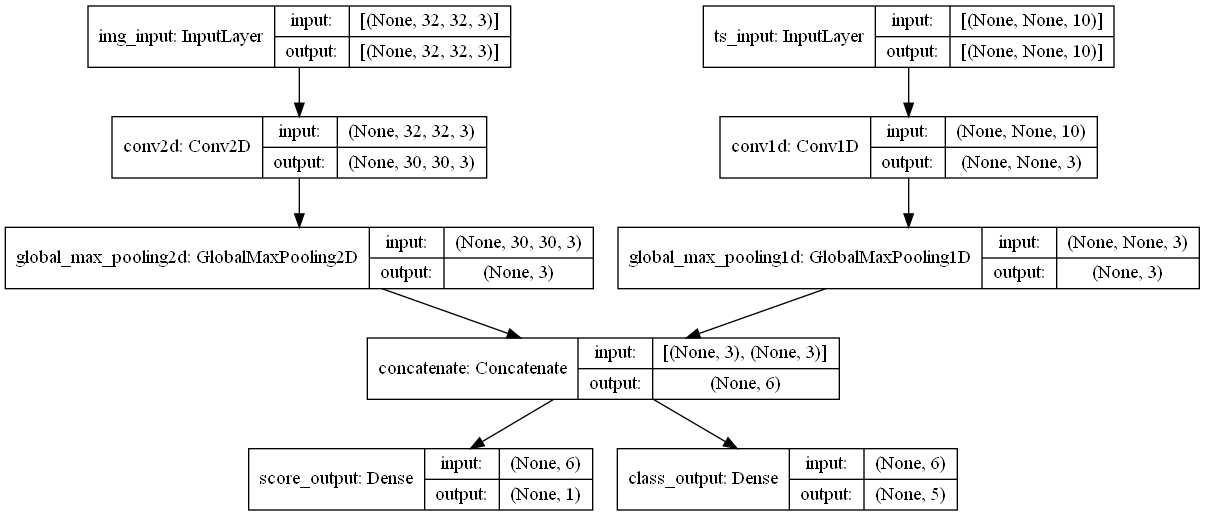

In [43]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [44]:
# specify different losses to different outputs, by passing the loss functions as a list
# 通过将损失函数列表来指定不同的损失函数
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

If we only passed a single loss function to the model, the same loss function would be applied to every output (which is not appropriate here).

如果你只传递了一个损失函数，那么这个函数会被应用于所有的输出（并不适用于目前的示例，因为计算得分是一个回归问题，计算类别概率是一个分类问题）

In [45]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
    metrics=[
        [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        [keras.metrics.CategoricalAccuracy()],
    ],
)

Since we gave names to our output layers, we could also specify per-output losses and metrics via a dict:

由于我们给每一个输出层命名了，所以我们可以通过字典来提前指定损失函数和指标

In [46]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
)

We recommend the use of explicit names and dicts if you have more than 2 outputs.

It's possible to give different weights to different output-specific losses (for instance, one might wish to privilege the "score" loss in our example, by giving to 2x the importance of the class loss), using the loss_weights argument:

我们建议，当你有2个及以上的输出时，采用名字和字典（来传递损失函数和指标参数）

通过loss_weights参数给不同的输出类别不同的权重也是可行的（比如，可以给分数损失更高的优先级，可以给于这类损失两倍的权重）

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
    loss_weights={"score_output": 2.0, "class_output": 1.0},
)

You could also choose not to compute a loss for certain outputs, if these outputs are meant for prediction but not for training:

你也可以选择不计算某些输出的损失，如果这些输出不是为了训练合适为了预测

In [48]:
# List loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()],
)

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={"class_output": keras.losses.CategoricalCrossentropy()},
)

Passing data to a multi-input or multi-output model in fit() works in a similar way as specifying a loss function in compile: you can pass lists of NumPy arrays (with 1:1 mapping to the outputs that received a loss function) or dicts mapping output names to NumPy arrays.

类似与指定compile（）方法的损失函数，通过fit()发放传递数据给多输入/输出模型也是类似的： 你可以传递Numpy数组列表（与接受损失函数的输出一一对应）或者字典（将输出的名称映射到Numpy数组）

In [49]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

# Generate dummy NumPy data
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# Fit on lists
model.fit([img_data, ts_data], [score_targets, class_targets], batch_size=32, epochs=1)

# Alternatively, fit on dicts
model.fit(
    {"img_input": img_data, "ts_input": ts_data},
    {"score_output": score_targets, "class_output": class_targets},
    batch_size=32,
    epochs=1,
)

4/4 [==============================] - 1s 8ms/step - loss: 10.3543 - score_output_loss: 0.1203 - class_output_loss: 10.2341


Here's the Dataset use case: similarly as what we did for NumPy arrays, the Dataset should return a tuple of dicts.

这是一个使用tf数据集对象的示例，和使用Numpy数组的示例非常相似。数据集对象会返回格式是包含字典的元组

In [50]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"img_input": img_data, "ts_input": ts_data},
        {"score_output": score_targets, "class_output": class_targets},
    )
)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

 model.fit(train_dataset, epochs=1)

2/2 [==============================] - 1s 19ms/step - loss: 10.2988 - score_output_loss: 0.1096 - class_output_loss: 10.1892


# Note 学习笔记

this part shows how to train/evaluate/predict a multiple input/output model.

because model has multiple output, so we can set different optimizer, metric, and loss for different output layers. And if we just set one optimizer, metric, and loss. the setting will be applied for all output layers

If we want to set multiple optimizers, metrics, and losses, they are two ways:
1. use list to pass the seting to compile()
2. create a dictionary object to mapping value based on layer name

What's more, if we use dictionary to do this, we must know the layer name. So it is important to give layer a good name

这一部分展示了如何训练/评估/预测一个多输入输出模型

因为模型有多个输出，所以我们可以为不同的输出层设置不一样的优化器，损失函数和评估指标。如果我们只设定了一个优化器，损失函数和评估指标，那么这个优化器，损失函数和评估指标会被应用于所有的输出层

如果我们想要设置多个优化器，损失函数和评估指标，有两种方式：
1. 在compile（）方法中通过列表来指定
2. 创建一个字典对象，实现层名称和具体设定值之间的映射

更重要的是，如果我们采用字典来实现这一过程，那么我们必须知道层的名称。因此，给层一个好的名称十分重要

## Using callbacks
## 使用回调

Callbacks in Keras are objects that are called at different points during training (at the start of an epoch, at the end of a batch, at the end of an epoch, etc.). They can be used to implement certain behaviors, such as:
1. Doing validation at different points during training (beyond the built-in per-epoch validation)
2. Checkpointing the model at regular intervals or when it exceeds a certain accuracy threshold
3. Changing the learning rate of the model when training seems to be plateauing
4. Doing fine-tuning of the top layers when training seems to be plateauing
5. Sending email or instant message notifications when training ends or where a certain performance threshold is exceeded
6. Etc.

在Keras中，回调是一类于调用时机与训练完全相反的对象（始于训练结束，而终于批量数据）它们被用于实现特定的行为，比如：
1. 在训练中不同的时机对模型进行验证（不是在每次训练结束后验证）
2. 间隔一定时间或者当模型超过了设定的准确性门槛时，设置检查点
3. 当模型训练结果趋于平缓时，改变模型的学习率
4. 当模型训练结果区域平缓时，对顶部层进行调参
5. 当训练结束或表现达到设定的门槛值时，发送邮件或特定的提示信息
6. 其他

In [51]:
# Callbacks can be passed as a list to your call to fit()
# 回调函数可以像列表一样传递给fit()
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        # 当验证器表现不再提升时，停止训练
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        # “不再提升”意味着提升分数不超过1e-2
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        # “不再提升”意味着比较最近两次训练的结果
        patience=2,
        verbose=1,
    )
]
model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    validation_split=0.2,
)

Epoch 1/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6162 - sparse_categorical_accuracy: 0.8313 - val_loss: 0.2368 - val_sparse_categorical_accuracy: 0.9274
Epoch 2/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1928 - sparse_categorical_accuracy: 0.9431 - val_loss: 0.1857 - val_sparse_categorical_accuracy: 0.9450
Epoch 3/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1326 - sparse_categorical_accuracy: 0.9618 - val_loss: 0.1639 - val_sparse_categorical_accuracy: 0.9501
Epoch 4/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1022 - sparse_categorical_accuracy: 0.9692 - val_loss: 0.1485 - val_sparse_categorical_accuracy: 0.9548
Epoch 5/20
625/625 [==============================] - 1s 2ms/step - loss: 0.0839 - sparse_categorical_accuracy: 0.9741 - val_loss: 0.1428 - val_sparse_categorical_accuracy: 0.9588
Epoch 6/20
625/625 [==============================] - 1s 2ms/step - loss: 0.0681 - sparse_categorica

### Many built-in callbacks are available
### 一些可用的内置回调函数

There are many built-in callbacks already available in Keras, such as:
1. ModelCheckpoint: Periodically save the model.
2. EarlyStopping: Stop training when training is no longer improving the validation metrics.
3. TensorBoard: periodically write model logs that can be visualized in TensorBoard (more details in the section "Visualization").
4. CSVLogger: streams loss and metrics data to a CSV file.
5. etc.

See the [callbacks documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/) for the complete list.

这里是一些Keras内置的回调函数：
1. ModelCheckpoint：周期性的保存模型
2. EarlyStopping：停止训练当训练不再提升验证指标
3. TensorBoard：周期性的记录模型日志并在TensorBoard中显示（更多细节参见“可视化”部分）
4. CSVLogger：将损失和指标数据保存为CSV文件
5. 其他

通过[回调函数文档](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/)来查阅完整的函数列表

### Writing your own callback
### 编写你自己的回调函数
You can create a custom callback by extending the base class keras.callbacks.Callback. A callback has access to its associated model through the class property self.model.

Make sure to read the [complete guide to writing custom callbacks](https://www.tensorflow.org/guide/keras/custom_callback/).

Here's a simple example saving a list of per-batch loss values during training:

你可以创建自定义的回调函数来扩充keras.callbacks.Callback类，一个回调函数可以通过类数据self.model来关联模型

确保已经阅读了[编写自定义回调函数(完全版)](https://www.tensorflow.org/guide/keras/custom_callback/)

In [53]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

# Note 学习笔记

This and following part show the power of callback object

In my opinion, the thing is that each part of a model only know the inforamtion from three channels: its input, output, and argument setting. Therefore, we cannot implement some feature because the related part don't know this information it need.

To solve this problem, we can uss the callback function. The callback object is a special part of models. it is not necessary for model, but it can access to all information in the model. So, we can implement some feature other method or fucntion cannot do by callback object, such as check point, learning rate decay, and logs visualization.


这一部分以及后续部分展示了回调函数的强大功能

在我看来，事情是这样的：模型的每一部分都只能从三个渠道来获取信息：他们的输入，他们的输出，以及设定的参数。因此，因为相关的模型组成部分无法获得必要的信息，我们可能无法实现某些功能。

为了解决这一问题，我们可以用到回调函数。回调函数是一种特别的模型组成部分：它不是必须的，但是它可以访问模型中的所有信息，因此，我们可以通过回调函数实现哪些其他方法和函数无法实现的功能，诸如检查点设置，学习率衰退，以及模型日志的可视化。



## Checkpointing models
## 检查点模型
When you're training model on relatively large datasets, it's crucial to save checkpoints of your model at frequent intervals.

The easiest way to achieve this is with the ModelCheckpoint callback:

当你训练一个大型数据集时，频繁的保存你的模型检查点至关重要

实现这一功能的最简便的办法是使用ModelCheckpoint回调函数

In [54]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # 保存路径
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # 以下两个参数意味着当模型指标（`val_loss` ）提升时，我们将覆盖最近的检查点
        # The saved model name will include the current epoch.
        # 保存的模型名称中包含当前的训练次数
        filepath="mymodel_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]
model.fit(
    x_train, y_train, epochs=2, batch_size=64, callbacks=callbacks, validation_split=0.2
)

Epoch 1/2
625/625 [==============================] - 3s 3ms/step - loss: 0.6059 - sparse_categorical_accuracy: 0.8337 - val_loss: 0.2245 - val_sparse_categorical_accuracy: 0.9319

Epoch 00001: val_loss improved from inf to 0.22450, saving model to mymodel_1
INFO:tensorflow:Assets written to: mymodel_1\assets
Epoch 2/2
625/625 [==============================] - 2s 3ms/step - loss: 0.1918 - sparse_categorical_accuracy: 0.9434 - val_loss: 0.1901 - val_sparse_categorical_accuracy: 0.9437

Epoch 00002: val_loss improved from 0.22450 to 0.19015, saving model to mymodel_2
INFO:tensorflow:Assets written to: mymodel_2\assets


The ModelCheckpoint callback can be used to implement fault-tolerance: the ability to restart training from the last saved state of the model in case training gets randomly interrupted. Here's a basic example:


ModelCheckpoint回调函数可以用于实现模型的容错性：从上一次保存的状态继续训练模型以防止训练过程被随机打断。以下是一个基本示例

In [55]:
import os

# Prepare a directory to store all the checkpoints.
# 准备一个字典来储存所有的检查点
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # 恢复最近的模型，或者在没有检查点可用时，创造一个新的模型
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()


model = make_or_restore_model()
callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the saved model name.
    # 这个回调函数会每经过100个批量数据就保存一次模型，保存的模型名称中包含训练集损失
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}", save_freq=100
    )
]
model.fit(x_train, y_train, epochs=1, callbacks=callbacks)

Creating a new model
1563/1563 [==============================] - 41s 26ms/step - loss: 0.5197 - sparse_categorical_accuracy: 0.8502


You call also write your own callback for saving and restoring models.

For a complete guide on serialization and saving, see [the guide to saving and serializing Models](https://www.tensorflow.org/guide/keras/save_and_serialize/).

你也可以自己编写回调函数来保存和回复模型

要保证的序列化和保存（模型），请参考[这边指南](https://www.tensorflow.org/guide/keras/save_and_serialize/)

## Using learning rate schedules
## 使用学习率设定函数
A common pattern when training deep learning models is to gradually reduce the learning as training progresses. This is generally known as "learning rate decay".

The learning decay schedule could be static (fixed in advance, as a function of the current epoch or the current batch index), or dynamic (responding to the current behavior of the model, in particular the validation loss).

一个训练深度学习模型的常见范式是逐步减少学习率，即学习率衰减

学习率衰减函数可是静态（开始是固定的学习率，类似一个基于最近的训练次数和批量次数的函数）或者动态的（对模型最近的行为产生反应，一般而言是对验证集损失产生反应）

### Passing a schedule to an optimizer
### 传递一个设定函数给优化器
You can easily use a static learning rate decay schedule by passing a schedule object as the learning_rate argument in your optimizer:

你可以轻易地将静态学习率衰减函数作为learning_rate参数传递给优化器

In [56]:
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

Several built-in schedules are available: ExponentialDecay, PiecewiseConstantDecay, PolynomialDecay, and InverseTimeDecay.

一些内置的衰减函数：ExponentialDecay, PiecewiseConstantDecay, PolynomialDecay, and InverseTimeDecay.

### Using callbacks to implement a dynamic learning rate schedule
### 利用回调函数应用动态学习率衰减设定函数
A dynamic learning rate schedule (for instance, decreasing the learning rate when the validation loss is no longer improving) cannot be achieved with these schedule objects, since the optimizer does not have access to validation metrics.

However, callbacks do have access to all metrics, including validation metrics! You can thus achieve this pattern by using a callback that modifies the current learning rate on the optimizer. In fact, this is even built-in as the ReduceLROnPlateau callback.

动态学习率衰减设定（例如，当验证集损失不在减少时，降低学习率）无法通过设定优化器参数来实现，因为优化器不知道验证集指标

然而，回调函数可以访问所有的指标，包括验证集指标！ 你可以通过使用回调函数来调整优化器中的学习率参数。实际上，这一功能已经成为了一个内置回调函数ReduceLROnPlateau

## Visualizing loss and metrics during training
## 训练过程中的损失和指标可视化
The best way to keep an eye on your model during training is to use TensorBoard -- a browser-based application that you can run locally that provides you with:

1. Live plots of the loss and metrics for training and evaluation
2. (optionally) Visualizations of the histograms of your layer activations
3. (optionally) 3D visualizations of the embedding spaces learned by your Embedding layers

在训练过程中关注模型的最佳实践是使用TensorBoard函数：一个你可以在本地运行的基于浏览器的应用。这个应用可以为你提供：
1. 为训练和验证过程绘制即时的损失和指标图像
2. 有必要的话，可以提供激活函数的直方图
3. 有需要的话，可以提供你的模型的潜入层的嵌入空间3D视图

If you have installed TensorFlow with pip, you should be able to launch TensorBoard from the command line:
如果你已经通过pip方式安装了TensorFlow，你可以通过命令行激活TensorBoard

In [ ]:
tensorboard --logdir=/full_path_to_your_logs

### Using the TensorBoard callback
### 使用TensorBoard回调函数

The easiest way to use TensorBoard with a Keras model and the fit() method is the TensorBoard callback.

In the simplest case, just specify where you want the callback to write logs, and you're good to go:

对于Keras模型和fit()方法而言，最便捷的调用TensorBoard的方式是使用TensorBoard回调函数

在最简单的情况下，只需要指定在哪里通过回调函数记录日志就可以了：

In [58]:
keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_logs",
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)

For more information, see the documentation for the TensorBoard callback.